In [1]:
import pandas as pd
import warnings
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore")


data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', header=0)

stocks = pd.DataFrame(data[0])


In [2]:
stocks.Symbol = stocks.Symbol.str.replace(".", "-")
stocks.set_index('Symbol', inplace=True, drop=True)
stock_prices = yf.download(list(stocks.index), '2022-1-1', auto_adjust=True, group_by='Symbol')


[*********************100%***********************]  503 of 503 completed


In [3]:
stock_prices.columns.levels

stock_prices = stock_prices.drop(['Open', 'High', 'Low', 'Volume'], level=1, axis=1)
stock_prices.tail()

,CZR,REGN,CDNS,A,BF-B,OGN,INTC,UNP,KR,DLR,...,SPGI,ABC,DPZ,PWR,KEY,KMI,GILD,NKE,UAL,ICE
,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-21,51.220001,746.520020,192.649994,143.419998,64.900002,26.755903,26.059999,193.750000,44.619999,108.410004,...,350.790009,160.839996,350.230011,148.699997,18.510000,17.35,84.639999,121.099998,48.200001,104.160004
2023-02-22,53.990002,748.080017,193.990005,142.080002,65.059998,26.548109,25.469999,191.380005,44.619999,106.639999,...,346.200012,160.130005,348.459991,148.399994,18.190001,17.32,83.500000,119.900002,48.779999,104.290001
2023-02-23,52.529999,759.659973,196.619995,143.199997,65.150002,26.369999,25.610001,193.320007,43.910000,108.760002,...,348.130005,159.500000,307.859985,159.619995,18.129999,17.48,82.540001,119.959999,50.580002,103.760002
2023-02-24,50.029999,756.989990,193.740005,141.199997,64.989998,25.590000,25.139999,194.020004,43.750000,105.040001,...,NaN,NaN,NaN,160.639999,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-27,51.480000,766.127319,193.987198,142.210007,65.180000,25.549999,25.060400,210.990005,43.529999,104.750000,...,341.515015,157.255005,294.559998,162.460007,18.190001,17.41,80.919998,118.845001,50.970001,101.379997


In [4]:
# Calculate top volatility decile

stock_prices.index = pd.to_datetime(stock_prices.index)

In [5]:
price_pct_change = stock_prices.pct_change()
price_pct_change.columns

MultiIndex([( 'CZR', 'Close'),
            ('REGN', 'Close'),
            ('CDNS', 'Close'),
            (   'A', 'Close'),
            ('BF-B', 'Close'),
            ( 'OGN', 'Close'),
            ('INTC', 'Close'),
            ( 'UNP', 'Close'),
            (  'KR', 'Close'),
            ( 'DLR', 'Close'),
            ...
            ('SPGI', 'Close'),
            ( 'ABC', 'Close'),
            ( 'DPZ', 'Close'),
            ( 'PWR', 'Close'),
            ( 'KEY', 'Close'),
            ( 'KMI', 'Close'),
            ('GILD', 'Close'),
            ( 'NKE', 'Close'),
            ( 'UAL', 'Close'),
            ( 'ICE', 'Close')],
           length=503)

In [6]:
# calculate standard deviation
stock_std = price_pct_change.std()
stock_std.axes

[MultiIndex([( 'CZR', 'Close'),
             ('REGN', 'Close'),
             ('CDNS', 'Close'),
             (   'A', 'Close'),
             ('BF-B', 'Close'),
             ( 'OGN', 'Close'),
             ('INTC', 'Close'),
             ( 'UNP', 'Close'),
             (  'KR', 'Close'),
             ( 'DLR', 'Close'),
             ...
             ('SPGI', 'Close'),
             ( 'ABC', 'Close'),
             ( 'DPZ', 'Close'),
             ( 'PWR', 'Close'),
             ( 'KEY', 'Close'),
             ( 'KMI', 'Close'),
             ('GILD', 'Close'),
             ( 'NKE', 'Close'),
             ( 'UAL', 'Close'),
             ( 'ICE', 'Close')],
            length=503)]

50


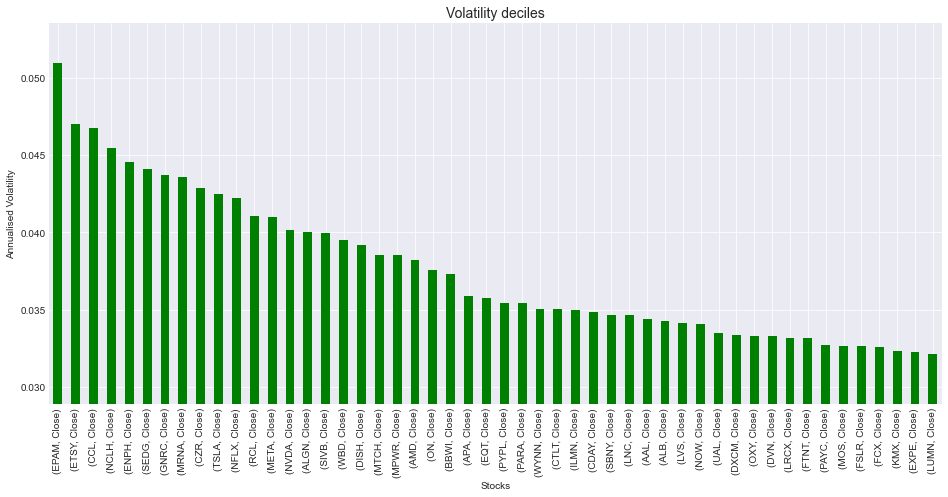

In [7]:
volatility_sort = stock_std.sort_values(ascending=False)
volatility_sort
topdecile = volatility_sort[:int(len(stock_std)*0.1)]
print(topdecile.count())
topdecile.plot.bar(figsize=(16,7),color='green',ylim=topdecile.min()*0.9)
plt.title('Volatility deciles', fontsize=14)
plt.xlabel('Stocks')
plt.ylabel('Annualised Volatility')
plt.show()

In [8]:
stock_prices_pc = stock_prices.loc['2022-1':,topdecile.index]

stock_prices_pc = stock_prices.pct_change()


In [10]:
topdecile.index

MultiIndex([('EPAM', 'Close'),
            ('ETSY', 'Close'),
            ( 'CCL', 'Close'),
            ('NCLH', 'Close'),
            ('ENPH', 'Close'),
            ('SEDG', 'Close'),
            ('GNRC', 'Close'),
            ('MRNA', 'Close'),
            ( 'CZR', 'Close'),
            ('TSLA', 'Close'),
            ('NFLX', 'Close'),
            ( 'RCL', 'Close'),
            ('META', 'Close'),
            ('NVDA', 'Close'),
            ('ALGN', 'Close'),
            ('SIVB', 'Close'),
            ( 'WBD', 'Close'),
            ('DISH', 'Close'),
            ('MTCH', 'Close'),
            ('MPWR', 'Close'),
            ( 'AMD', 'Close'),
            (  'ON', 'Close'),
            ('BBWI', 'Close'),
            ( 'APA', 'Close'),
            ( 'EQT', 'Close'),
            ('PYPL', 'Close'),
            ('PARA', 'Close'),
            ('WYNN', 'Close'),
            ('CTLT', 'Close'),
            ('ILMN', 'Close'),
            ('CDAY', 'Close'),
            ('SBNY', 'Close'),
        

In [ ]:

portfolio = pd.DataFrame()
portfolio['returns'] = stock_prices_pc.mean(axis=1)
portfolio['value'] = (portfolio+1).cumprod()
portfolio = portfolio.dropna()
portfolio.value.plot(color='b',figsize=(10,7))
plt.ylabel("Portfolio value")
plt.show()

In [ ]:
import numpy as np
def get_strategy_returns_sma(portfolio):
    # Calculate the simple moving average of period 10
    portfolio['sma10'] = portfolio.value.rolling(window=50).mean()
    # Create a trading signal
    portfolio['signal'] = np.where(portfolio.value > portfolio.sma10,1,0)
    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

def plot_signal(portfolio):
    portfolio['value'].plot(color='blue')    
    plt.fill_between(portfolio.index, portfolio.value, where=(portfolio.signal==1), facecolor='g', alpha=0.2)      
    plt.legend()
    plt.ylabel('Portfolio Value',color='r')
    # Plot the signal values    
    portfolio['signal'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
    plt.ylabel('Signal',color='r')
    plt.show()

portfolio = get_strategy_returns_sma(portfolio)    
plot_signal(portfolio)  

In [ ]:
def plot_returns_dd(portfolio):
    # ----------- Sharpe ratio ------------------
    sharpe_ratio = np.mean(portfolio.str_returns)/np.std(portfolio.str_returns)*(252**0.5)
    print('The Sharpe ratio is %.2f ' % sharpe_ratio)

    # ----------- Cumulative strategy returns ------------------
    portfolio['cum_str_returns'] = (portfolio['str_returns']+1).cumprod()
    # Plot the cumulative strategy returns
    portfolio['cum_str_returns'].plot(figsize=(10,7), color='green')
    plt.title('Strategy Returns', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.show()        

    # ----------- Drawdown ------------------    
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio['cum_str_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (portfolio['cum_str_returns'])/running_max - 1
    max_dd = drawdown.min()*100
    print('The maximum drawdown is %.2f' % max_dd)
    # Plot the drawdowns
    drawdown.plot(color='r',figsize=(10,10))
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()    
    
plot_returns_dd(portfolio)   

In [ ]:
def get_strategy_returns_breakout(portfolio):
    # Calculate the breakout indicator values
    portfolio['high'] = portfolio.value.rolling(window=3).max()
    # Create a trading signal
    portfolio['signal'] = np.where(portfolio.value>=portfolio.high,1,0)
    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

portfolio = get_strategy_returns_breakout(portfolio)
# plot_signal(portfolio)    
plot_returns_dd(portfolio)

In [ ]:

def get_strategy_returns_sma_breakout(portfolio):
    # Calculate the simple moving average 
    sma20 = portfolio.value > portfolio.value.rolling(window=20).mean()
    # Calculate the breakout indicator values
    breakout = portfolio.value>=portfolio.value.rolling(window=20).max()
   
    
    # Create a trading signal
    portfolio['signal'] = np.where(sma20 & breakout > 0.55 ,1,0)

    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio


def plot_signal(portfolio):
    portfolio['value'].plot(color='blue')    
    plt.fill_between(portfolio.index, portfolio.value, where=(portfolio.signal==1), facecolor='g', alpha=0.2)      
    plt.legend()
    plt.ylabel('Portfolio Value',color='r')
    # Plot the signal values    
    portfolio['signal'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
    plt.ylabel('Signal',color='r')
    plt.show()
    
portfolio = get_strategy_returns_sma_breakout(portfolio)
plot_signal(portfolio)    
plot_returns_dd(portfolio)
